In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB 

In [6]:
def MIP(N, S, L, w_0, w_t, alpha, lq, vol, M, ls, cs):
    
    L_sec = L[0:S]
    L_names = L[S]
    L_tickets = L[S+1]
    L_alpha = L[S+2]
    L_illiquidity = L[S+3]
    L_tc = L[S+4]

    #gp.Env.setParam("OutputFlag",0)
    
        #Model
    m = gp.Model("MIP")
    
    #Variables
    Names = m.addMVar((N, 1), vtype=GRB.BINARY, name="Names")
    Tickets = m.addMVar((N, 1), vtype=GRB.BINARY, name="Tickets")
    Weights = m.addMVar((N, 1), lb=0.0, vtype=GRB.CONTINUOUS, name="Weigths")

    Y = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="Y")
    F = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="F")
    X = m.addMVar((S, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="X")

    x_1 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="x_1")
    x_2 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="x_2")
    x_3 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="x_3")

    z_1 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="z_1")
    z_2 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="z_2")
    z_3 = m.addMVar((N, 1), lb = 0.0, vtype=GRB.CONTINUOUS, name="z_3")

    #Constraints

    #Sum of Weights
    m.addConstr(Weights.sum() == 1, 'Sum of weights')
    #Constraints on Y[i]
    m.addConstrs((Weights[i] - w_t[i] <= Y[i] for i in range(N)), name='Y+')
    m.addConstrs((-(Weights[i] - w_t[i]) <= Y[i] for i in range(N)), name='Y-')
    #Constraints on F[i]
    m.addConstrs((Weights[i] - w_0[i] <= F[i] for i in range(N)), name='F+')
    m.addConstrs((-(Weights[i] - w_0[i]) <= F[i] for i in range(N)), name='F-')    
    #Constraints with X[s]
    m.addConstrs((X[s] >= np.sum(M[s][i]*(Weights[i] - w_t[i]) for i in range(N)) for s in range(S)), name='X+')
    m.addConstrs((X[s] >= -np.sum(M[s][i]*(Weights[i] - w_t[i]) for i in range(N)) for s in range(S)), name='X-')
    #Binary flag for Names
    m.addConstrs((Weights[i] <= Names[i] for i in range(N)), name='W<N')
    #Binary flag for Tickets
    m.addConstrs((F[i] <= Tickets[i] for i in range(N)), name='F<T')
    #Constraints for Liquidity
    m.addConstrs((Weights[i] == x_1[i] + x_2[i] + x_3[i] for i in range(N)),name='W=x1+x2+x3')
    #Components of Liquidity Constraints
    m.addConstrs((x_1[i] <= lq[i] for i in range(N)), name='x1')
    m.addConstrs((x_2[i] <= lq[i] for i in range(N)), name='x2')
    m.addConstrs((x_3[i] <= 2*lq[i] for i in range(N)), name='x3')
    #Constraints for Volatility
    m.addConstrs((F[i] == z_1[i] + z_2[i] + z_3[i] for i in range(N)), name='F=z1+z2+z3')
    #Components of Volatility Constraints
    m.addConstrs((z_1[i] <= 0.1*vol[i] for i in range(N)), name='z1')
    m.addConstrs((z_2[i] <= 0.2*vol[i] for i in range(N)), name='z2')
    m.addConstrs((z_3[i] <= 0.2*vol[i] for i in range(N)), name='z3')

    #Objective Function
    m.setObjective((Y.sum() + 
                    np.sum(L_sec[i] * X[i] for i in range(S)) +
                    L_names*Names.sum() + 
                    L_tickets*Tickets.sum() - 
                    L_alpha*np.sum(alpha[i]*Weights[i] for i in range(N)) + 
                    L_illiquidity*np.sum((ls[i][0]*x_1[i] + ls[i][1]*x_2[i] + ls[i][2]*x_3[i]) for i in range(N)) + 
                    L_tc*np.sum((cs[i][0]*z_1[i] + cs[i][1]*z_2[i] + cs[i][2]*z_3[i]) for i in range(N)))
                    , GRB.MINIMIZE)

    m.optimize()
    
    for v in m.getVars():
        print(f'{v.VarName} = {v.x}')

    if m.Status == GRB.INFEASIBLE:
        m.computeIIS()
        print('\nThe following constraints and variables are in the IIS:')
        for c in m.getConstrs():
            if c.IISConstr: print(f'\t{c.constrname}: {m.getRow(c)} {c.Sense} {c.RHS}')


    return Weights.x


In [7]:
data = pd.read_excel(r"C:\Users\alewi\Desktop\HKUST & PoliMi\Prescriptive Analytics\Project\DATA.xlsx", sheet_name="GENERAL") 

N = pd.DataFrame(data, columns=["N"])
N = int(N.dropna().to_numpy()[0])

S = pd.DataFrame(data, columns=["S"])
S = int(S.dropna().to_numpy()[0])

L = pd.DataFrame(data, columns=["L"])
L = L.dropna().to_numpy()

data1 = pd.read_excel(r"C:\Users\alewi\Desktop\HKUST & PoliMi\Prescriptive Analytics\Project\DATA.xlsx", sheet_name="WT in time") 
w_t = pd.DataFrame(data1)
w_t = w_t.dropna().to_numpy()

data2 = pd.read_excel(r"C:\Users\alewi\Desktop\HKUST & PoliMi\Prescriptive Analytics\Project\DATA.xlsx", sheet_name="VOLUME") 
vol = pd.DataFrame(data2)
vol = vol.dropna().to_numpy()

data3 = pd.read_excel(r"C:\Users\alewi\Desktop\HKUST & PoliMi\Prescriptive Analytics\Project\DATA.xlsx", sheet_name="alpha") 
alpha = pd.DataFrame(data3)
alpha = alpha.dropna().to_numpy()

lq = pd.DataFrame(data, columns=["LQ"])
lq = lq.dropna().to_numpy()


M = pd.DataFrame(data, columns=["0003.HK","0066.HK","0386.HK","0270.HK","0175.HK",
                                "0168.HK","0151.HK","2319.HK","2318.HK","2202.HK",
                                "1929.HK","1928.HK","1398.HK","1128.HK","1093.HK",
                                "0941.HK","0914.HK","0857.HK","0753.HK","0700.HK"])
M = M.dropna().to_numpy()


w_0 = np.ones([N,1])/N
w_f = np.zeros([N,49])

names = ["0003.HK","0066.HK","0386.HK","0270.HK","0175.HK",
                                "0168.HK","0151.HK","2319.HK","2318.HK","2202.HK",
                                "1929.HK","1928.HK","1398.HK","1128.HK","1093.HK",
                                "0941.HK","0914.HK","0857.HK","0753.HK","0700.HK"]

for i in range(48):
    w_t_loop = w_t[:,i]
    vol_loop = vol[:,i]

    alpha_loop = np.transpose(alpha[i][:])

    #I suppose that both are following the law f(x) = x^2 for ease of use
    ls = np.concatenate([np.power(lq,2), np.power(2*lq,2), np.power(4*lq,2)], axis=1)

    cs = np.zeros([3,20])
    cs[:][0] = np.transpose(np.power(0.1*vol_loop,2))
    cs[:][1] = np.transpose(np.power(0.3*vol_loop,2))
    cs[:][2] = np.transpose(np.power(0.5*vol_loop,2))

    cs = np.transpose(cs)
    
    print(cs)

    w_f[:,i+1] = MIP(N, S, L, w_0, w_t_loop, alpha_loop, lq, vol_loop, M, ls, cs).reshape(-1)
    w_0 = w_f[:,i]


    
    




C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3204643908.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N = int(N.dropna().to_numpy()[0])
C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3204643908.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = int(S.dropna().to_numpy()[0])
C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3753500305.py:43: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  m.addConstrs((X[s] >= np.sum(M[s][i]*(Weights[i] - w_t[i]) for i in range(N)) for s in range(S)), name='X+

[[2.61250062e-03 2.35125056e-02 6.53125154e-02]
 [1.12784223e-03 1.01505800e-02 2.81960557e-02]
 [5.86005572e-03 5.27405015e-02 1.46501393e-01]
 [3.77954624e-03 3.40159162e-02 9.44886561e-02]
 [3.15332501e-03 2.83799251e-02 7.88331254e-02]
 [4.31968613e-03 3.88771752e-02 1.07992153e-01]
 [7.24451625e-03 6.52006462e-02 1.81112906e-01]
 [2.14138184e-03 1.92724366e-02 5.35345461e-02]
 [3.74388005e-02 3.36949205e-01 9.35970013e-01]
 [5.14200253e-02 4.62780228e-01 1.28550063e+00]
 [3.40777036e-02 3.06699332e-01 8.51942589e-01]
 [2.03760141e-03 1.83384127e-02 5.09400352e-02]
 [1.24118820e-02 1.11706938e-01 3.10297051e-01]
 [2.87681736e-04 2.58913562e-03 7.19204339e-03]
 [8.62695650e-04 7.76426085e-03 2.15673913e-02]
 [4.28948713e-03 3.86053842e-02 1.07237178e-01]
 [7.71419334e-03 6.94277400e-02 1.92854833e-01]
 [4.13156344e-03 3.71840710e-02 1.03289086e-01]
 [1.03065537e-03 9.27589830e-03 2.57663842e-02]
 [2.62327448e-03 2.36094703e-02 6.55818619e-02]]
Gurobi Optimizer version 10.0.3 build v

C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3753500305.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(L_sec[i] * X[i] for i in range(S)) +
C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3753500305.py:67: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  L_alpha*np.sum(alpha[i]*Weights[i] for i in range(N)) +
C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3753500305.py:68: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  L_illiquidity*np.sum((ls[i][0]*x_1[i] + ls[i][1]*x_2[i] + ls[i][2]*x_3[i]) for i in range(N)) +
C:\Users\alewi\AppData\Local\Temp\ipykernel_8156\3753500305.

Names[0,0] = 1.0
Names[1,0] = 1.0
Names[2,0] = 1.0
Names[3,0] = 0.0
Names[4,0] = 1.0
Names[5,0] = 0.0
Names[6,0] = 1.0
Names[7,0] = 0.0
Names[8,0] = 1.0
Names[9,0] = 1.0
Names[10,0] = 1.0
Names[11,0] = 1.0
Names[12,0] = 1.0
Names[13,0] = 1.0
Names[14,0] = 1.0
Names[15,0] = 1.0
Names[16,0] = 1.0
Names[17,0] = 1.0
Names[18,0] = 1.0
Names[19,0] = 1.0
Tickets[0,0] = 1.0
Tickets[1,0] = 1.0
Tickets[2,0] = 1.0
Tickets[3,0] = 1.0
Tickets[4,0] = 1.0
Tickets[5,0] = 1.0
Tickets[6,0] = 1.0
Tickets[7,0] = 1.0
Tickets[8,0] = 1.0
Tickets[9,0] = 1.0
Tickets[10,0] = 1.0
Tickets[11,0] = 1.0
Tickets[12,0] = 1.0
Tickets[13,0] = 1.0
Tickets[14,0] = 1.0
Tickets[15,0] = 1.0
Tickets[16,0] = 1.0
Tickets[17,0] = 1.0
Tickets[18,0] = 1.0
Tickets[19,0] = 1.0
Weigths[0,0] = 0.017673566219337588
Weigths[1,0] = 0.01693235440030129
Weigths[2,0] = 0.03999999999999915
Weigths[3,0] = 0.0
Weigths[4,0] = 0.03999999999999915
Weigths[5,0] = 0.0
Weigths[6,0] = 0.010304346030074588
Weigths[7,0] = 0.0
Weigths[8,0] = 0.073842726

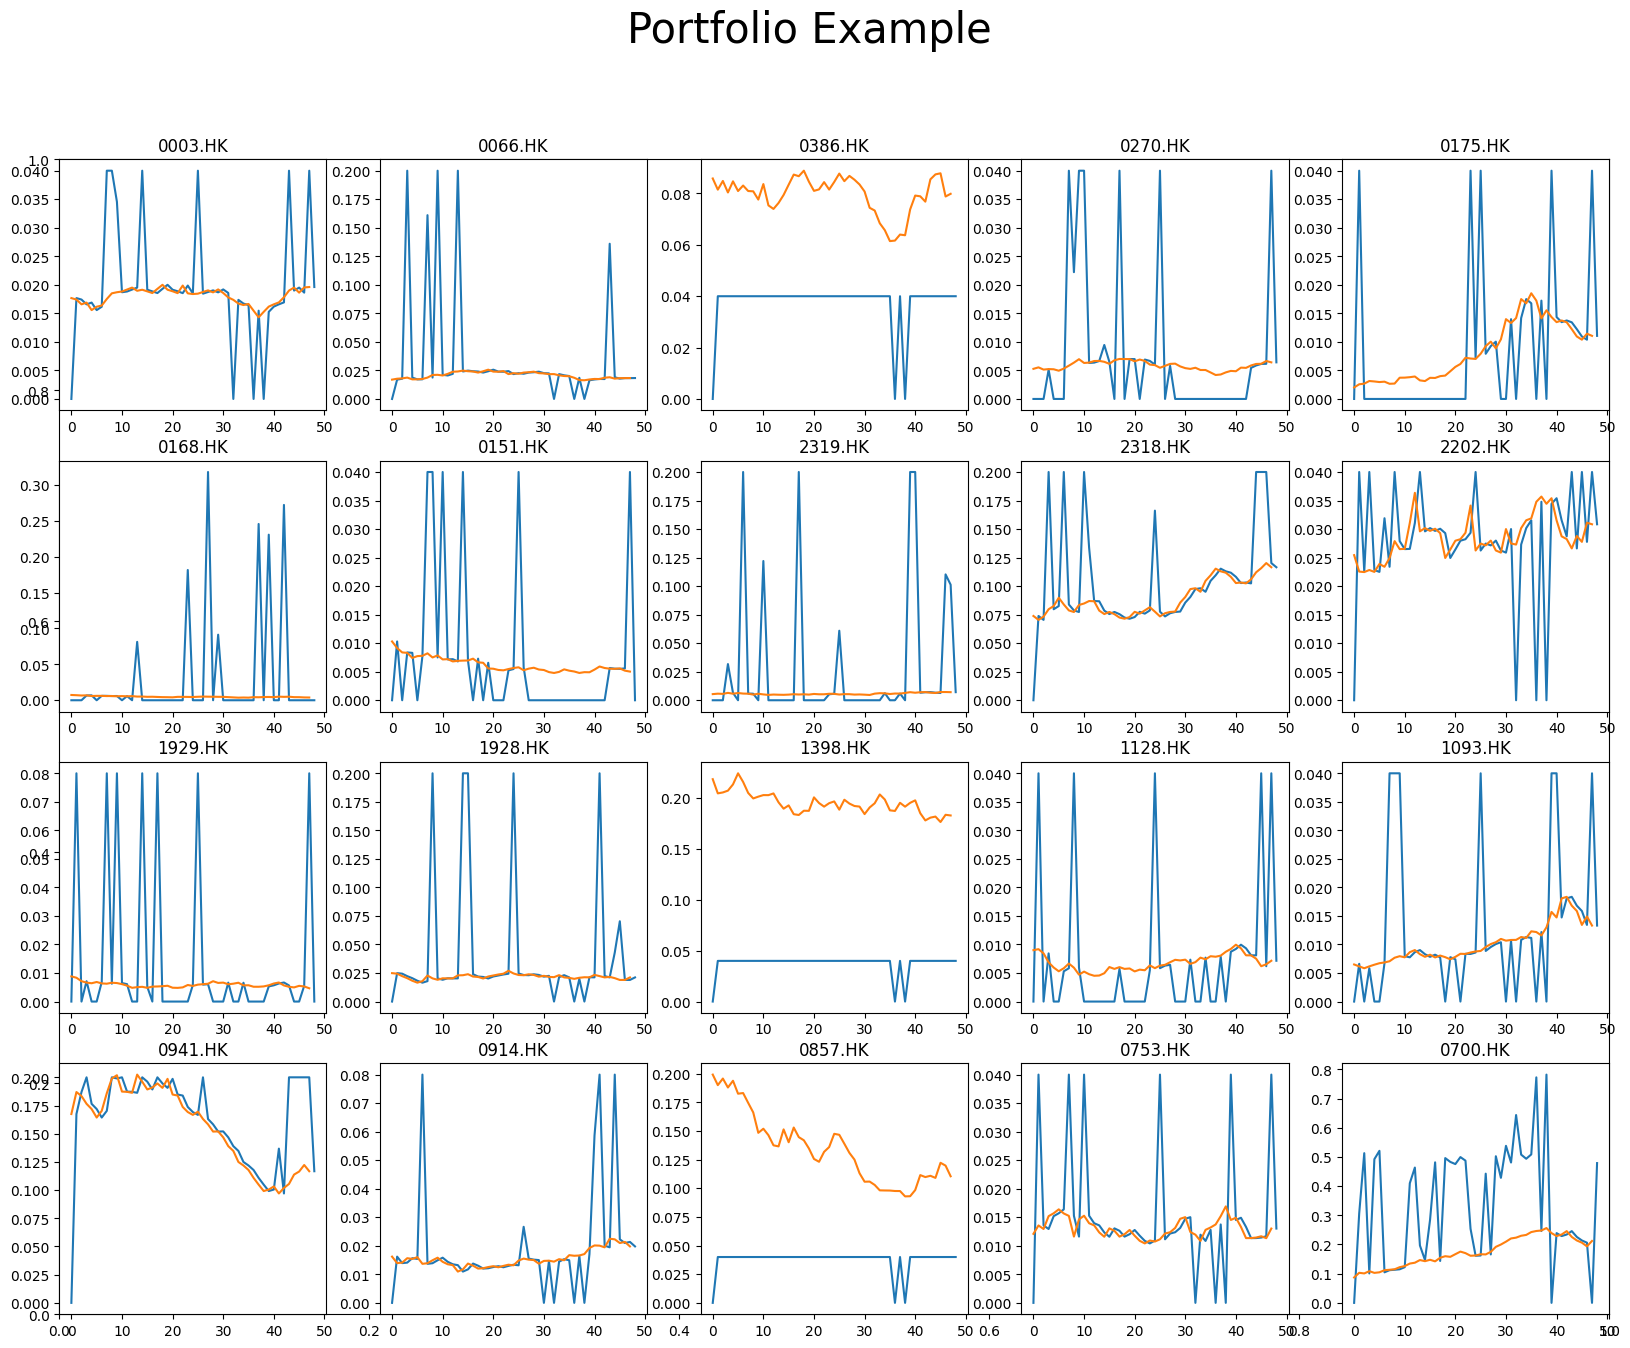

In [8]:

fig = plt.subplots(figsize=(20,15))
for i in range(20):
    fig = plt.subplot(4,5,i+1)
    plt.title(names[i])
    plt.plot(range(49), w_f[i,:])
    plt.plot(range(48), w_t[i,:])
    
plt.suptitle("Portfolio Example", fontsize=30)
plt.savefig("Portfolio Example.jpg")
